# *US Domestic flights from 1990 to 2009*
- 3 **MILLION** lines. That's a lot !
- [Public Dataset](http://academictorrents.com/details/a2ccf94bbb4af222bf8e69dad60a68a29f310d9a) published by the US Census Bureau



# Prepare the Data

## Import Libraries

In [0]:
from __future__ import print_function

import pandas as pd
import numpy as np
import yaml
import time, datetime
import os.path, sys

# MatPlotLib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


## Import Dataset

In [0]:
# Dataset Download : http://academictorrents.com/details/a2ccf94bbb4af222bf8e69dad60a68a29f310d9a
if not os.path.isfile("./flights/flights.tsv") or not os.path.isfile("./flights/metadata.csv"):
  !wget https://drive.arnaud.at/flights.zip
  !unzip flights.zip -d ./flights

# Parsing csv files
raw_flights = pd.read_csv("./flights/flights.tsv", sep="\t")
metadata = pd.read_csv("./flights/metadata.csv", sep=",")
airports = pd.read_csv("https://datahub.io/core/airport-codes/r/airport-codes.csv", sep=",")


## Data Cleanup

In [0]:
flights = raw_flights.copy() # Deep copy of raw data

flights.columns = metadata['Short name'] # Set column names

useless_columns = ['Origin City', 'Destination City'] # Drop useless columns
flights = flights.drop(useless_columns, axis=1)

flights = flights.rename({'Seats': 'seats',  # Rename columns
                          'Origin': 'origin',
                          'Destination': 'destination', 
                          'Passengers':'people', 
                          'Flights':'flights', 
                          'Distance':'distance_miles', 
                          'Origin Population': 'pop_origin', 
                          'Destination Population':'pop_destination',
                          'Fly Date':'date'
                          }, axis='columns')


flights = flights[flights['seats']+flights['people']>0]  # Delete Empty planes

flights['occupation'] = flights['people']/(flights['seats']+flights['people'])  # Calculate occupation percentage

flights['date'] = pd.to_datetime(flights['date'], format='%Y%m', errors='ignore') # Calculate date

flights.head() # Show first 5 rows

Short name,origin,destination,people,seats,flights,distance_miles,date,pop_origin,pop_destination,occupation
0,EUG,RDM,41,396,22,103.0,1990-11-01,284093,76034,0.093822
1,EUG,RDM,88,342,19,103.0,1990-12-01,284093,76034,0.204651
2,EUG,RDM,11,72,4,103.0,1990-10-01,284093,76034,0.132530
3,MFR,RDM,0,18,1,156.0,1990-02-01,147300,76034,0.000000
4,MFR,RDM,11,18,1,156.0,1990-03-01,147300,76034,0.379310


# Let's do stuff with our Data

## Seat occupancy by year

Text(0.5, 0, 'Year')

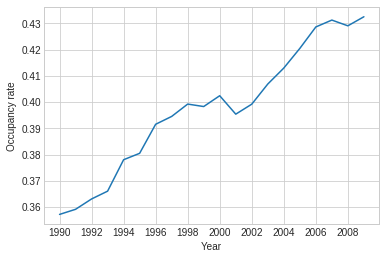

In [0]:
means = []
years = pd.date_range(start='1990', end='2009', freq='YS')

for year in years:
  year_flights = flights[flights['date'].between(year, year+datetime.timedelta(days=365))]
  mean = year_flights['people'].sum()/(year_flights['seats']+year_flights['people']).sum()
  means.append(float(mean))

ax = plt.axes()

ax.plot(years,means)
plt.ylabel("Occupancy rate")
plt.xlabel("Year")

## Million of passengers by month

Text(0.4, 0.95, '9/11 attacks')

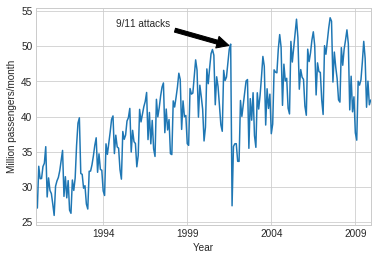

In [0]:
axe1 = flights.groupby("date")['people'].sum().div(1e6).plot()

plt.ylabel("Million passengers/month")
plt.xlabel("Year")

nine_eleven = datetime.date(2001, 9, 11)
axe1.annotate('9/11 attacks',
            xy=(nine_eleven, 50), xycoords='data',
            xytext=(0.4, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')

## Mapping the top 100 airports

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[None, None, None, None, None, None]

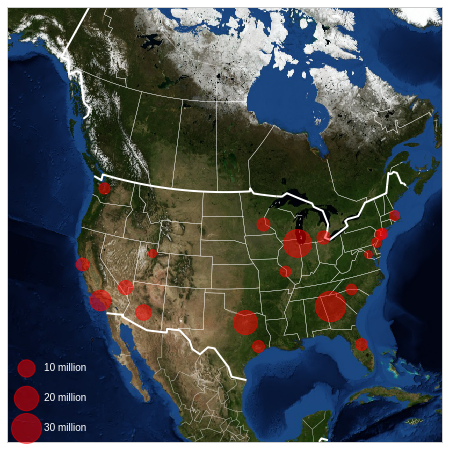

In [0]:
if 'mpl_toolkits' not in sys.modules: # Install MPL if not present
  !apt-get install libgeos-3.5.0
  !apt-get install libgeos-dev
  !pip install https://github.com/matplotlib/basemap/archive/master.zip
  !pip install pyproj==1.9.6

fig = plt.figure(figsize=(8, 8)) # Create Map
basemap = Basemap(projection='lcc', resolution="c", width=6E6, height=6E6, lat_0=45, lon_0=-100)
basemap.bluemarble(scale=1)
basemap.drawcountries(color='w', linewidth=2)
basemap.drawstates(color='w', linewidth=0.3)

# Select top Airports
top_airports = flights.groupby('origin')['people'].sum().sort_values(ascending=False).div(1e6).div(19).head(100)

for airport, people in top_airports.items(): # Plot every top airport
  coordinates = airports[airports['iata_code'] == airport].coordinates.values[0].split(', ')
  x, y = basemap(*coordinates)
  plt.plot(x, y, 'or', markersize=people, alpha=0.5)
  
for a in [10, 20, 30]: # Scatter point legend
    plt.scatter([], [], c='r', alpha=0.5, s=a*30, label= str(a) + ' million')
legend = plt.legend(scatterpoints=1, frameon=False, labelspacing=2, loc='lower left')
plt.setp(legend.get_texts(), color='w')

## More Documentation



[Line Plots](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.01-Simple-Line-Plots.ipynb#scrollTo=p1PX2IxUGm44)  
[Scatter Plots](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.02-Simple-Scatter-Plots.ipynb#scrollTo=Ly5il5dmGmt2)  
[Mapping](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.13-Geographic-Data-With-Basemap.ipynb#scrollTo=JsDWFhYaCKU2)

```
df = flights.sample(frac=0.01) # Take a 1% sample    
df = df.sort_values('occupation', ascending=True) # Sort dataset
```